# Use Time Series BYOM and time series data to predict energy demand


#### Disclaimers

- Use only Projects and Spaces that are available in watsonx context.

## Notebook content

This notebook demonstrates the process of deploying model for Time Series as well as its use for multivariate forecasting tasks and showcases the variety of features available in Time Series Foundation Models.

Some familiarity with Python is helpful. This notebook uses Python 3.11.

## Learning goals

The learning goals of this notebook are:

- Store TS model previously available in your COS
- Deploy TS model
- To explore Time Series BYOM
- To forecast based on historical data

## Contents

This notebook contains the following parts:

1. [Setup](#setup)
2. [Deploy model](#deploy)
3. [Prepare dataset](#dataset)
4. [Initialize forecast](#init)
5. [Forecast](#forecast)
6. [Summary](#summary)


<a id="setup"></a>

## 1. Set up the environment

Before you use the sample code in this notebook, you must perform the following setup tasks:

- Create a <a href="https://cloud.ibm.com/catalog/services/watsonxai-runtime" target="_blank" rel="noopener no referrer">watsonx.ai Runtime Service</a> instance (a free plan is offered and information about how to create the instance can be found <a href="https://dataplatform.cloud.ibm.com/docs/content/wsj/getting-started/wml-plans.html?context=wx&audience=wdp" target="_blank" rel="noopener no referrer">here</a>).


### Install and import the `ibm-watsonx-ai` and dependecies

**Note:** `ibm-watsonx-ai` documentation can be found <a href="https://ibm.github.io/watsonx-ai-python-sdk/index.html" target="_blank" rel="noopener no referrer">here</a>.


In [ ]:
!pip install wget | tail -n 1
!pip install -U matplotlib | tail -n 1
!pip install -U "ibm-watsonx-ai>=1.1.31" | tail -n 1

### Defining the watsonx.ai credentials

This cell defines the watsonx.ai credentials required to work with watsonx Foundation Model inferencing.

**Action:** Provide the IBM Cloud user API key. For details, see <a href="https://cloud.ibm.com/docs/account?topic=account-userapikey&interface=ui" target="_blank" rel="noopener no referrer">documentation</a>.


In [ ]:
import getpass
from ibm_watsonx_ai import Credentials

credentials = Credentials(
    url="https://us-south.ml.cloud.ibm.com",
    api_key=getpass.getpass("Please enter your watsonx.ai api key (hit enter): "),
)

### Defining the project id

The deploymeny of Time Series FM requires project id that provides the context for the call. We will obtain the id from the project in which this notebook runs. Otherwise, please provide the project id.


In [ ]:
from ibm_watsonx_ai import APIClient

client = APIClient(
    credentials,
    project_id=getpass.getpass("Please enter your project_id (hit enter): "),
)

<a id="deploy"></a>

## 2. Deploy the model

Once you have initialized the client it is time to deploy custom model. Provide information about where your model is stored below, unless you have not created a connection.


- CONNECTION_ID - connection asset ID to your data source which will store custom foundation model files.
- BUCKET_NAME - bucket which will store your custom foundation models files.
- FILE_PATH - path to your custom foundation models files. In most cases empty string - "".


In [ ]:
CONNECTION_ID="PASTE YOUR CONNECTON ID HERE",
BUCKET_NAME="PASTE YOUR BUCKET NAME HERE",
FILE_PATH="PASTE YOUR FILE PATH HERE"

### Create custom model repository


In [ ]:
sw_spec_id = client.software_specifications.get_id_by_name("watsonx-tsfm-runtime-1.0")

In [ ]:
metadata = {
    client.repository.ModelMetaNames.NAME: "time series FM",
    client.repository.ModelMetaNames.SOFTWARE_SPEC_ID: sw_spec_id,
    client.repository.ModelMetaNames.TYPE: "custom_foundation_model_1.0",
    client.repository.ModelMetaNames.FOUNDATION_MODEL: {
        "model_id": "my_test_time_series_model",
    },
    client.repository.ModelMetaNames.MODEL_LOCATION: {
        "connection_id": CONNECTION_ID,
        "bucket": BUCKET_NAME,
        "file_path": FILE_PATH,
    },
}

model = "my_test_time_series_model"

In [ ]:
stored_base_model_details = client.repository.store_model(
    model=model, meta_props=metadata
)

In [ ]:
stored_model_id = stored_base_model_details["metadata"]["id"]
stored_model_id

'209931e6-55c3-490b-ad2f-96cbfc3b5501'

### Perform custom model deployment


In [ ]:
meta_props = {
    client.deployments.ConfigurationMetaNames.NAME: "custom_tsfm_python_sdk",
    client.deployments.ConfigurationMetaNames.ONLINE: {
        "parameters": {
            "serving_name": "custom_tsfm_python_sdk",
            "foundation_model": {},
        },
    },
    client.deployments.ConfigurationMetaNames.HARDWARE_SPEC: {
        "name": "S",
        "num_nodes": 1,
    },
}

In [13]:
base_model_deployment_details = client.deployments.create(stored_model_id, meta_props)



######################################################################################

Synchronous deployment creation for id: '209931e6-55c3-490b-ad2f-96cbfc3b5501' started

######################################################################################


initializing.......
Note: Deployment of custom foundation model with architecture tinytimemixer is not supported. Deployment might fail.
........................
ready


-----------------------------------------------------------------------------------------------
Successfully finished deployment creation, deployment_id='3c4af901-4460-4bf7-a274-670ff4a33f8d'
-----------------------------------------------------------------------------------------------




In [ ]:
deployment_id = base_model_deployment_details["metadata"]["id"]

<a id="dataset"></a>

## 3. Prepare training dataset

This tutorial uses the [Hourly energy demand dataset](https://github.com/IBM/watson-machine-learning-samples/raw/refs/heads/master/cloud/data/energy/energy_dataset.csv) dataset, which contains four years of electrical consumption and generation data for Spain. It is a modified version of the [Hourly energy demand generation and weather](https://www.kaggle.com/datasets/nicholasjhana/energy-consumption-generation-prices-and-weather/data). For simplicity, the dataset has been prepared to have no missing values and no irrelevant columns."


In [ ]:
import os
import wget

filename = "energy_dataset.csv"
base_url = "https://github.com/IBM/watsonx-ai-samples/raw/refs/heads/master/cloud/data/energy/"

if not os.path.isfile(filename):
    wget.download(base_url + filename)

In [16]:
import pandas as pd

df = pd.read_csv(filename)

Show the last few rows of the dataset.


In [17]:
df.tail()

,time,generation biomass,generation fossil brown coal/lignite,generation fossil gas,generation fossil hard coal,generation fossil oil,generation hydro pumped storage consumption,generation hydro run-of-river and poundage,generation hydro water reservoir,generation nuclear,generation other,generation other renewable,generation solar,generation waste,generation wind onshore,forecast solar day ahead,forecast wind onshore day ahead,total load forecast,total load actual
35059,2018-12-31 19:00:00,297.0,0.0,7634.0,2628.0,178.0,1.0,1135.0,4836.0,6073.0,63.0,95.0,85.0,277.0,3113.0,96.0,3253.0,30619.0,30653.0
35060,2018-12-31 20:00:00,296.0,0.0,7241.0,2566.0,174.0,1.0,1172.0,3931.0,6074.0,62.0,95.0,33.0,280.0,3288.0,51.0,3353.0,29932.0,29735.0
35061,2018-12-31 21:00:00,292.0,0.0,7025.0,2422.0,168.0,50.0,1148.0,2831.0,6076.0,61.0,94.0,31.0,286.0,3503.0,36.0,3404.0,27903.0,28071.0
35062,2018-12-31 22:00:00,293.0,0.0,6562.0,2293.0,163.0,108.0,1128.0,2068.0,6075.0,61.0,93.0,31.0,287.0,3586.0,29.0,3273.0,25450.0,25801.0
35063,2018-12-31 23:00:00,290.0,0.0,6926.0,2166.0,163.0,108.0,1069.0,1686.0,6075.0,61.0,92.0,31.0,287.0,3651.0,26.0,3117.0,24424.0,24455.0


Describe the data.


In [18]:
df.describe()

,generation biomass,generation fossil brown coal/lignite,generation fossil gas,generation fossil hard coal,generation fossil oil,generation hydro pumped storage consumption,generation hydro run-of-river and poundage,generation hydro water reservoir,generation nuclear,generation other,generation other renewable,generation solar,generation waste,generation wind onshore,forecast solar day ahead,forecast wind onshore day ahead,total load forecast,total load actual
count,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000
mean,383.532797,448.091918,5622.705653,4256.550622,298.341319,475.563997,972.206337,2605.496121,6263.501854,60.225416,85.634326,1432.804957,269.419205,5465.115589,1439.066735,5471.216689,28712.129962,28697.608573
std,85.346455,354.616732,2201.557635,1961.973297,52.518371,792.291849,400.714694,1835.074561,840.244555,20.238846,14.076953,1680.007595,50.217172,3213.736451,1677.703355,3176.312853,4594.100854,4575.872425
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,237.000000,18105.000000,18041.000000
25%,333.000000,0.000000,4126.000000,2527.000000,263.000000,0.000000,637.000000,1078.000000,5759.000000,53.000000,73.000000,71.000000,240.000000,2933.000000,69.000000,2979.000000,24793.750000,24806.750000
50%,367.000000,509.000000,4969.500000,4475.000000,300.000000,68.000000,906.000000,2165.000000,6564.000000,57.000000,88.000000,616.000000,279.000000,4849.000000,576.000000,4855.000000,28906.000000,28902.000000
75%,433.000000,757.000000,6429.000000,5839.000000,330.000000,616.000000,1250.000000,3757.250000,7025.000000,80.000000,97.000000,2579.000000,310.000000,7399.500000,2636.000000,7353.000000,32263.250000,32194.250000
max,592.000000,999.000000,20034.000000,8359.000000,449.000000,4523.000000,2000.000000,9728.000000,7117.000000,106.000000,119.000000,5792.000000,357.000000,17436.000000,5836.000000,17430.000000,41390.000000,41015.000000


### Split the data

The purpose of this notebook is to demonstrate the core functionality of features available in Time Series Foundation Models. The selected model,
requires a minimum context length of 1024. Therefore, the dataset will be split into a historical dataset containing 1024 rows, while the next 96 lines will be used to check the consistency of the predictions.


In [19]:
timestamp_column = "time"
target_column = "total load actual"
context_length = 1320
future_context = 96

In [20]:
# Only use the last `context_length` rows for prediction.
future_data = df.iloc[-future_context:,]
data = df.iloc[-context_length:-future_context,]

### Visualize the data


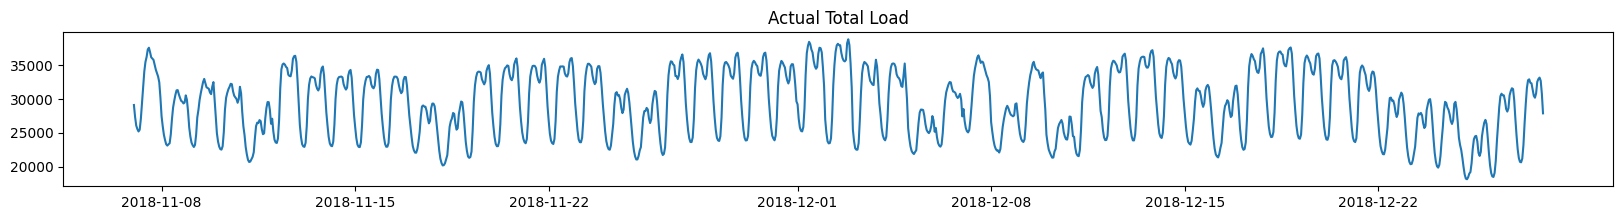

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(20, 2))
plt.plot(np.asarray(data[timestamp_column], "datetime64[s]"), data[target_column])
plt.title("Actual Total Load")
plt.show()

<a id="init"></a>

## 4. Initialize the `TSModelInference` class.


`TSModelInference` is a wrapper for time series models available from watsonx.ai, designed to forecast future values based on historical data.


In [ ]:
from ibm_watsonx_ai.foundation_models import TSModelInference

ts_model = TSModelInference(deployment_id=deployment_id, api_client=client)

### Defining the model parameters

We need to provide a set of model parameters that will influence the result:


In [ ]:
from ibm_watsonx_ai.foundation_models.schema import TSForecastParameters

forecasting_params = TSForecastParameters(
    timestamp_column=timestamp_column,
    freq="1h",
    target_columns=[target_column],
)

<a id="forecast"></a>

## 5. Forecasting

Call the `forecast()` method to predict energy consumption.


In [ ]:
results = ts_model.forecast(data=data, params=forecasting_params)["results"][0]

### Plot predictions along with the historical data.


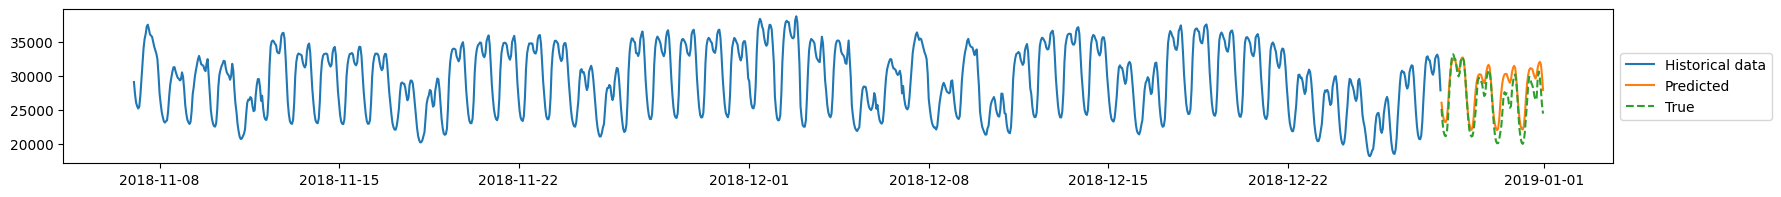

In [ ]:
plt.figure(figsize=(20, 2))
plt.plot(
    np.asarray(data[timestamp_column], dtype="datetime64[s]"),
    data[target_column],
    label="Historical data",
)
plt.plot(
    np.asarray(results[timestamp_column], dtype="datetime64[s]"),
    results[target_column],
    label="Predicted",
)
plt.plot(
    np.asarray(future_data[timestamp_column], dtype="datetime64[s]"),
    future_data[target_column],
    label="True",
    linestyle="dashed",
)
plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
plt.show()

<a id="summary"></a>

## 6. Summary and next steps

You successfully completed this notebook!

You learned how to use Time Series BYOM in real life applications.

Check out our _[Online Documentation](https://www.ibm.com/cloud/watson-studio/autoai)_ for more samples, tutorials, documentation, how-tos, and blog posts.


### Authors

**Filip Żmijewski**, Software Engineer at watsonx.ai.


Copyright © 2025 IBM. This notebook and its source code are released under the terms of the MIT License.
